In [1]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline
plt.rcParams["figure.dpi"] = 300
np.set_printoptions(precision=3, suppress=True)
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale, StandardScaler

In [3]:
import openml
# mammography dataset https://www.openml.org/d/310
data = openml.datasets.get_dataset(310)

In [4]:
X, y = data.get_data(target=data.default_target_attribute)

In [5]:
X.shape

(11183, 6)

In [6]:
np.bincount(y)

array([10923,   260])

In [7]:
X.min(axis=0)

array([-0.784, -0.47 , -0.592, -0.86 , -0.378, -0.946], dtype=float32)

In [8]:
df = pd.DataFrame(X)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f3e05aa2f98>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f3e034769b0>]], dtype=object)

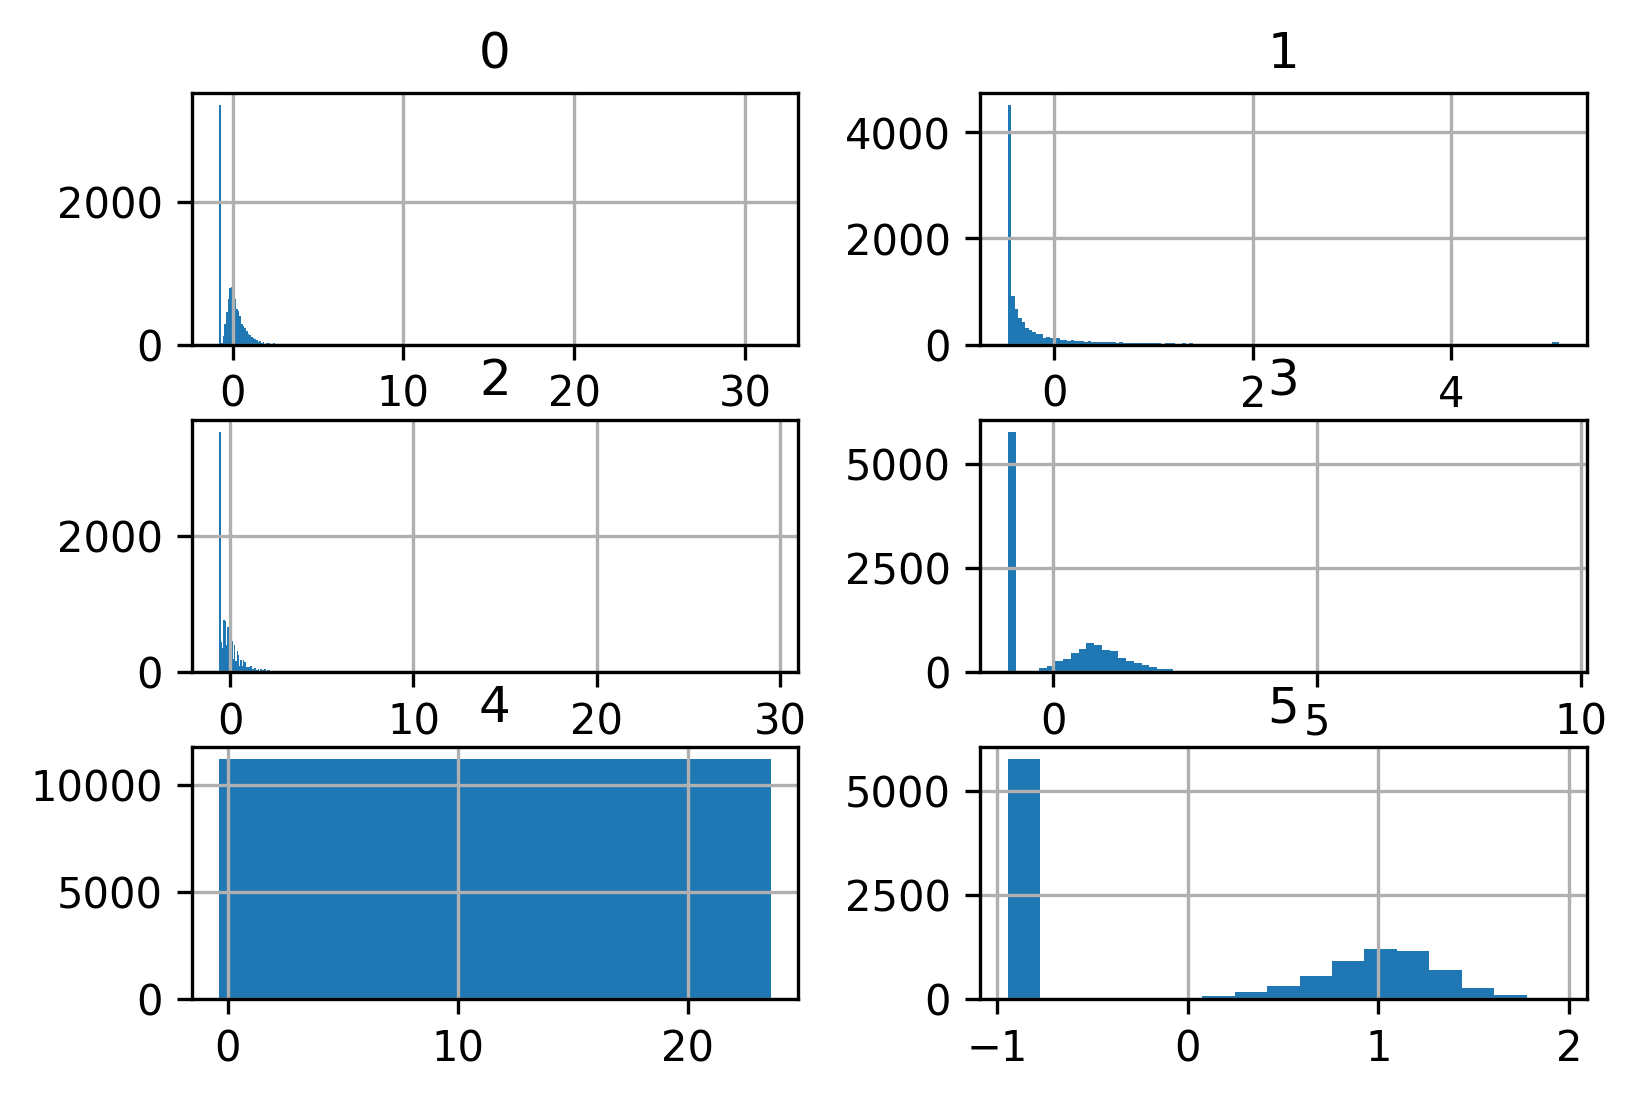

In [9]:
df.hist(bins='auto')

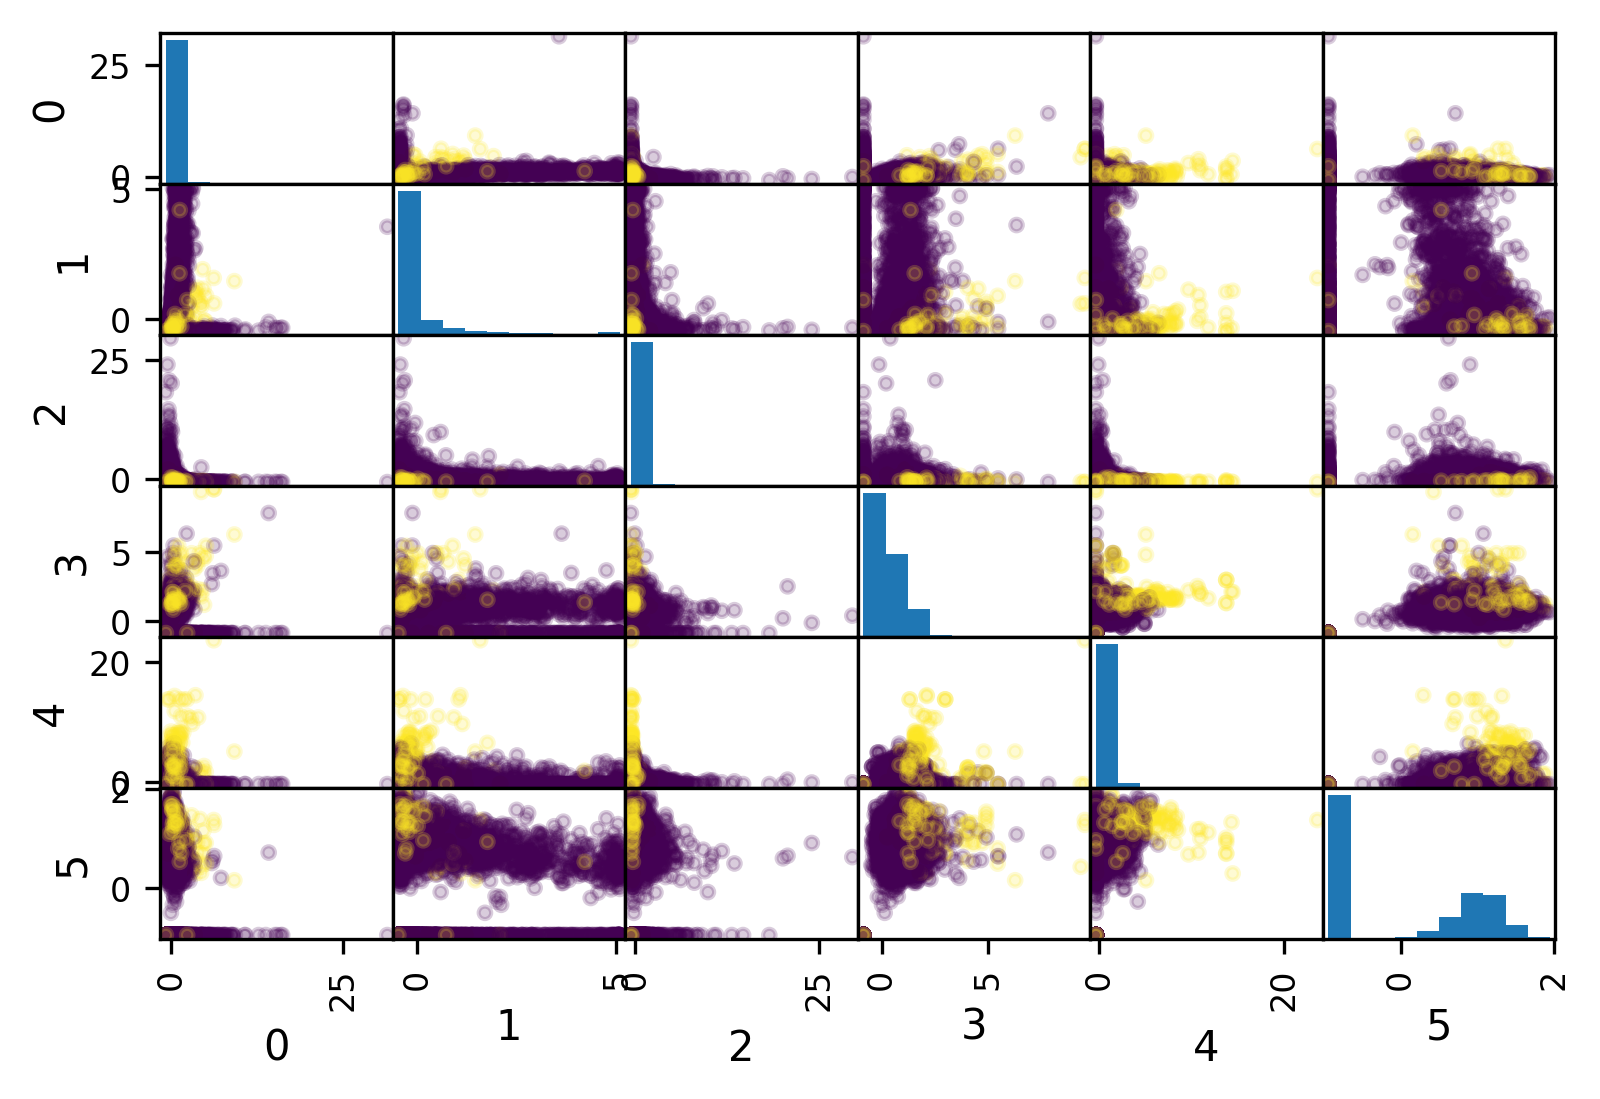

In [10]:
pd.scatter_matrix(df, c=y, alpha=.2);

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=0)

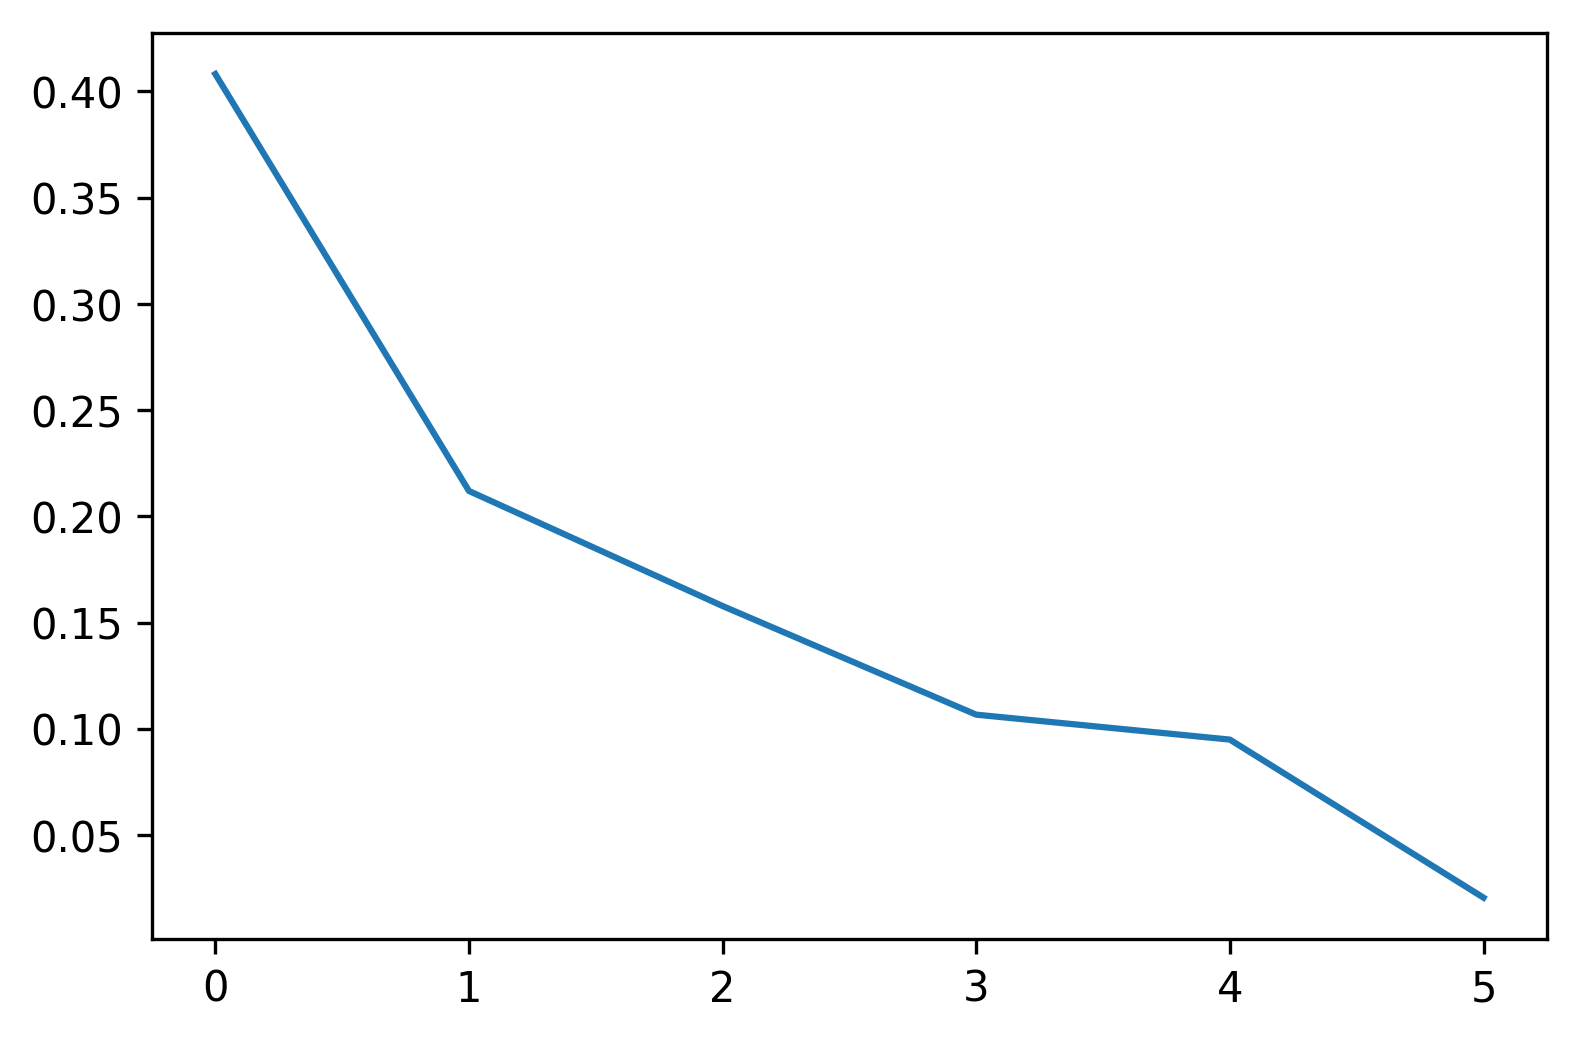

In [12]:
from sklearn.decomposition import PCA
pca = PCA()
X_train_pca = pca.fit_transform(X_train)
plt.plot(pca.explained_variance_ratio_)

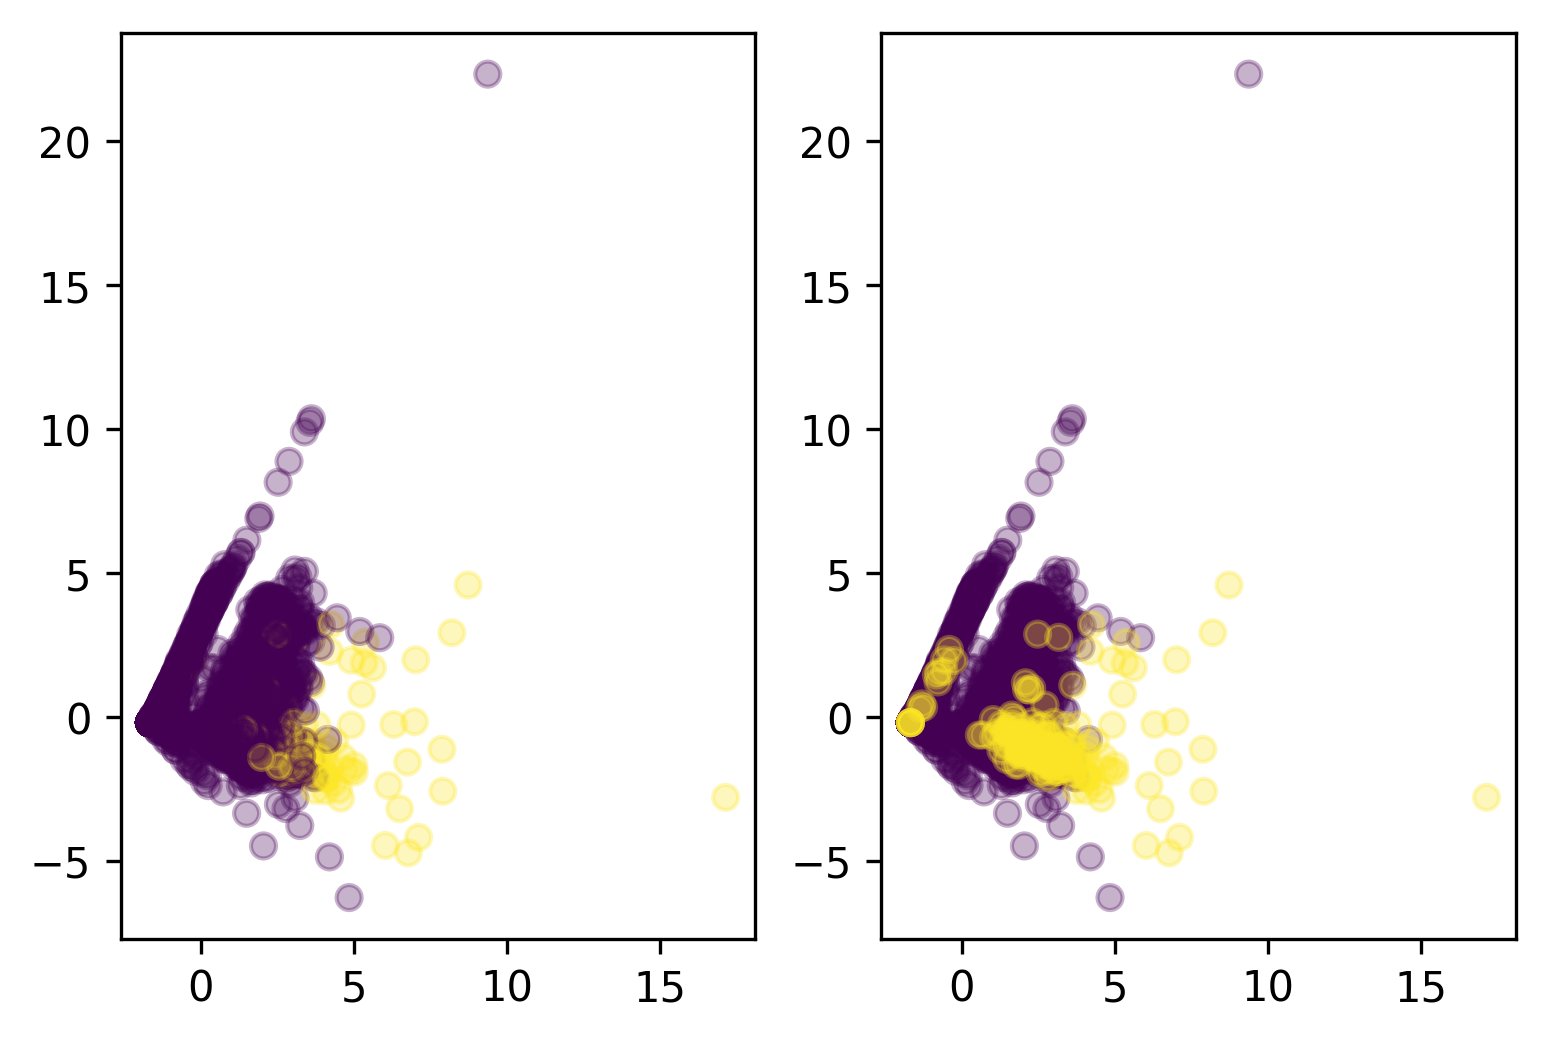

In [121]:
sorting = np.argsort(y_train)
fig, axes = plt.subplots(1, 2)
axes[0].scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train[:], alpha=.3)
axes[1].scatter(X_train_pca[sorting, 0], X_train_pca[sorting, 1], c=y_train[sorting], alpha=.3)

In [14]:
from sklearn.preprocessing import RobustScaler
rs = RobustScaler().fit(X_train)
X_train_scaled = rs.transform(X_train)

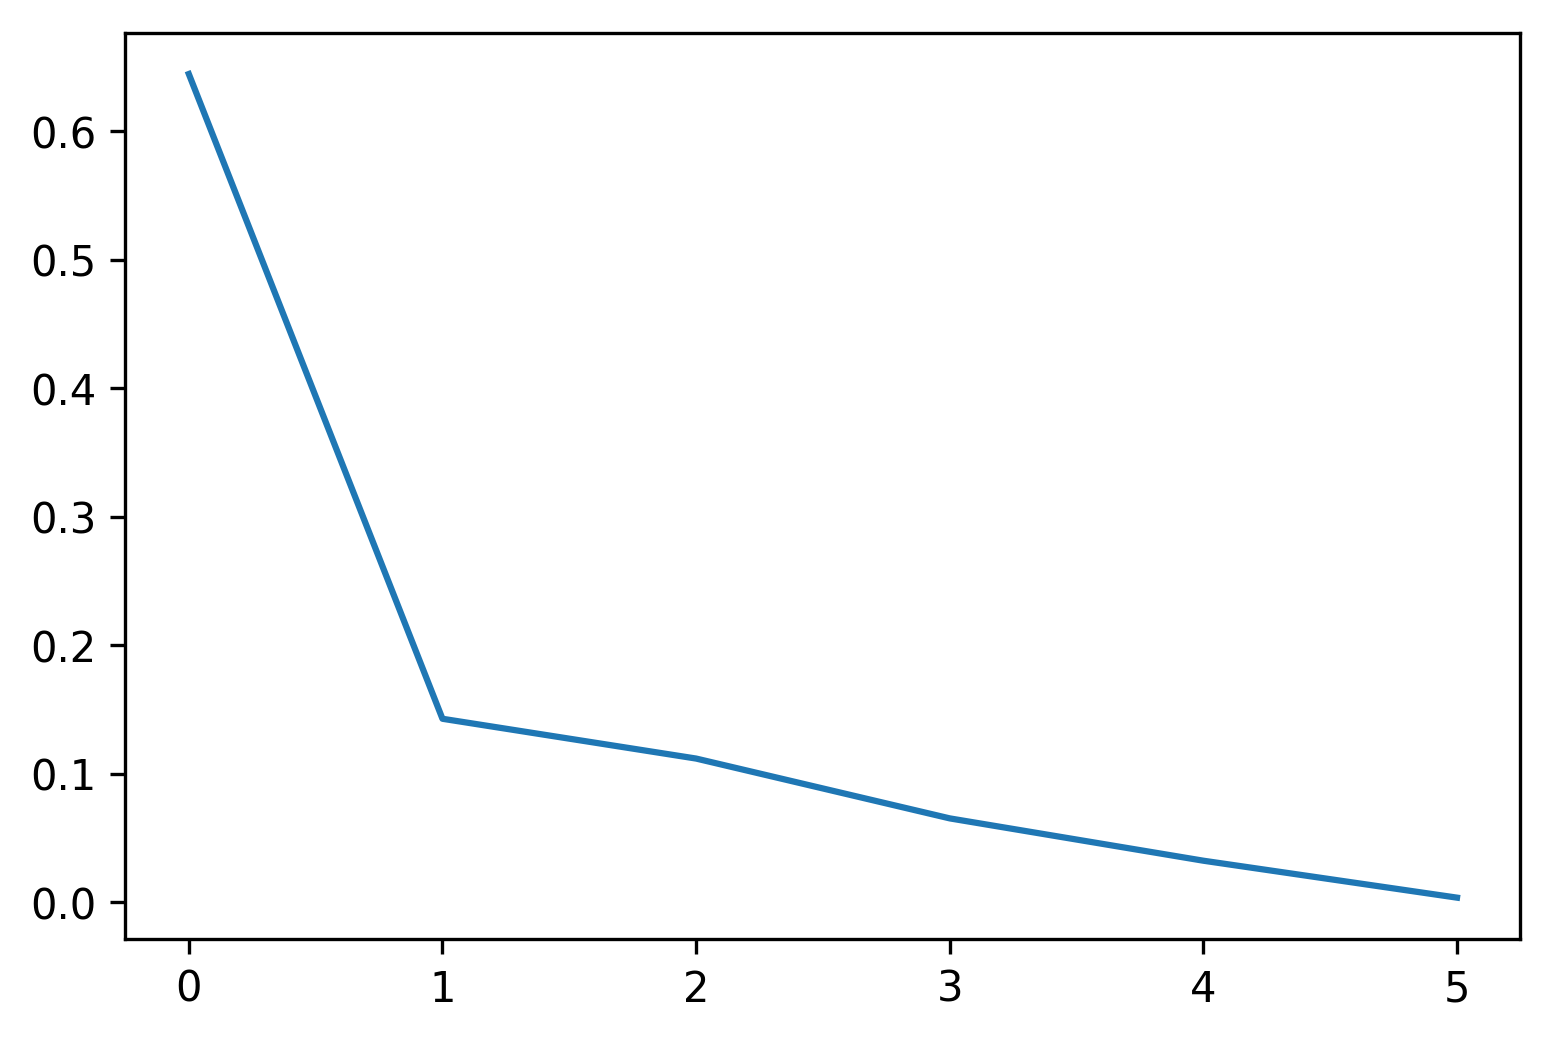

In [15]:
pca_scaled = PCA()
X_train_pca_scaled = pca_scaled.fit_transform(X_train_scaled)
plt.plot(pca_scaled.explained_variance_ratio_)

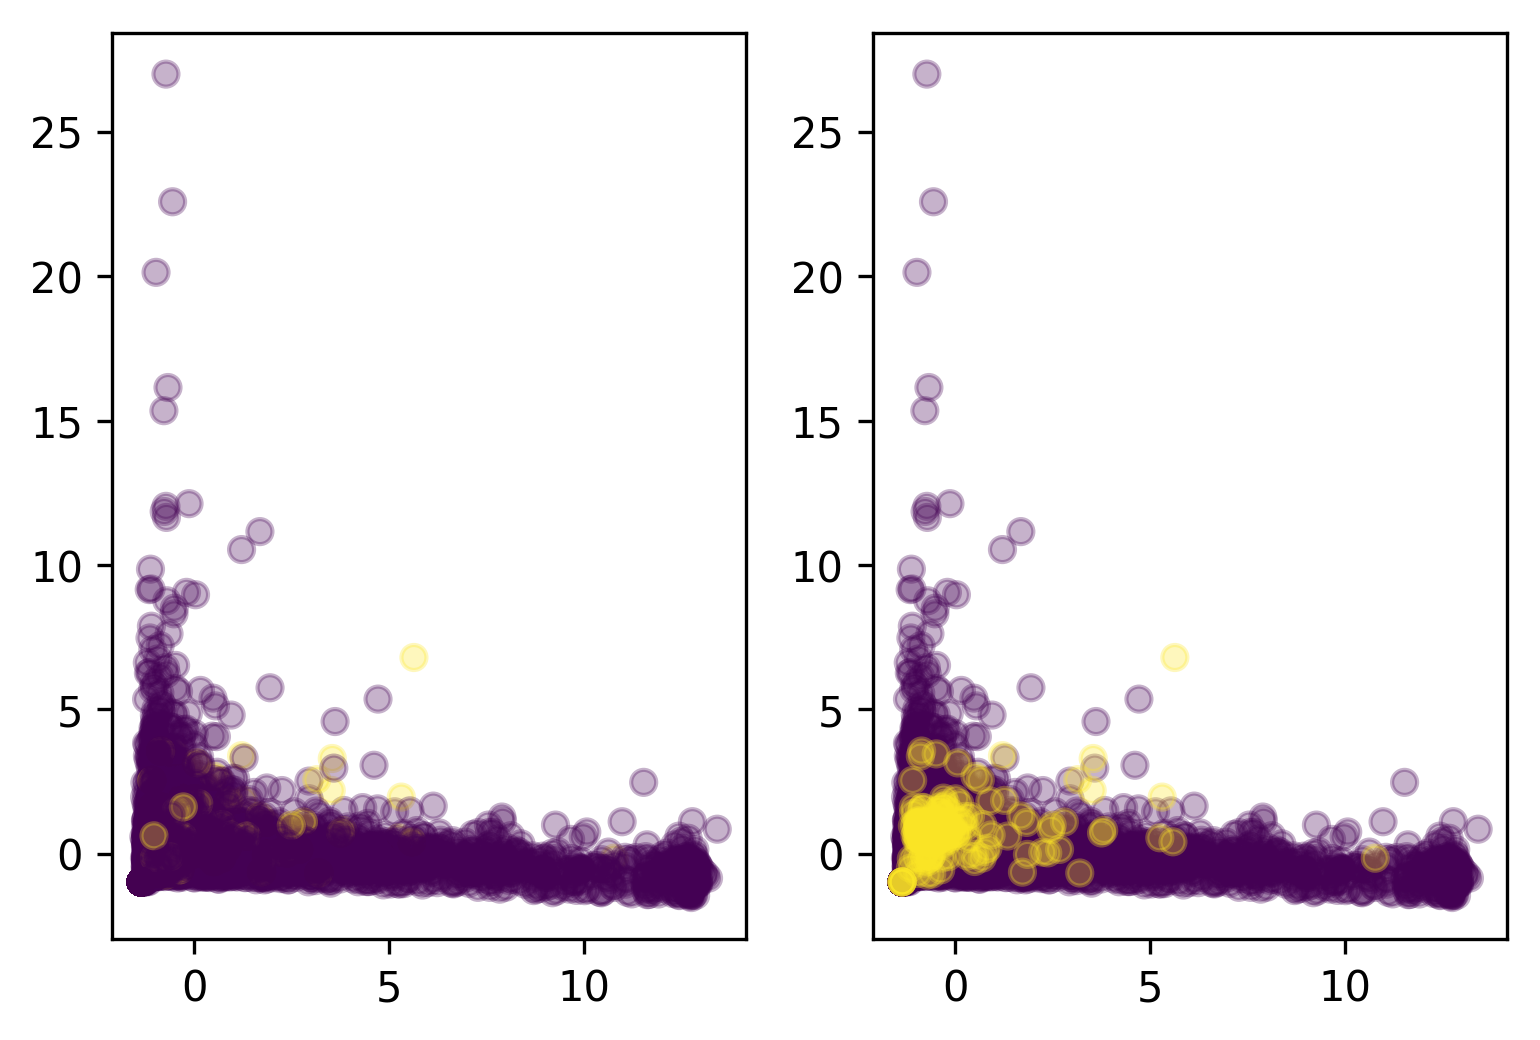

In [122]:
fig, axes = plt.subplots(1, 2)
axes[0].scatter(X_train_pca_scaled[:, 0], X_train_pca_scaled[:, 1], c=y_train[:], alpha=.3)
axes[1].scatter(X_train_pca_scaled[sorting, 0], X_train_pca_scaled[sorting, 1], c=y_train[sorting], alpha=.3)

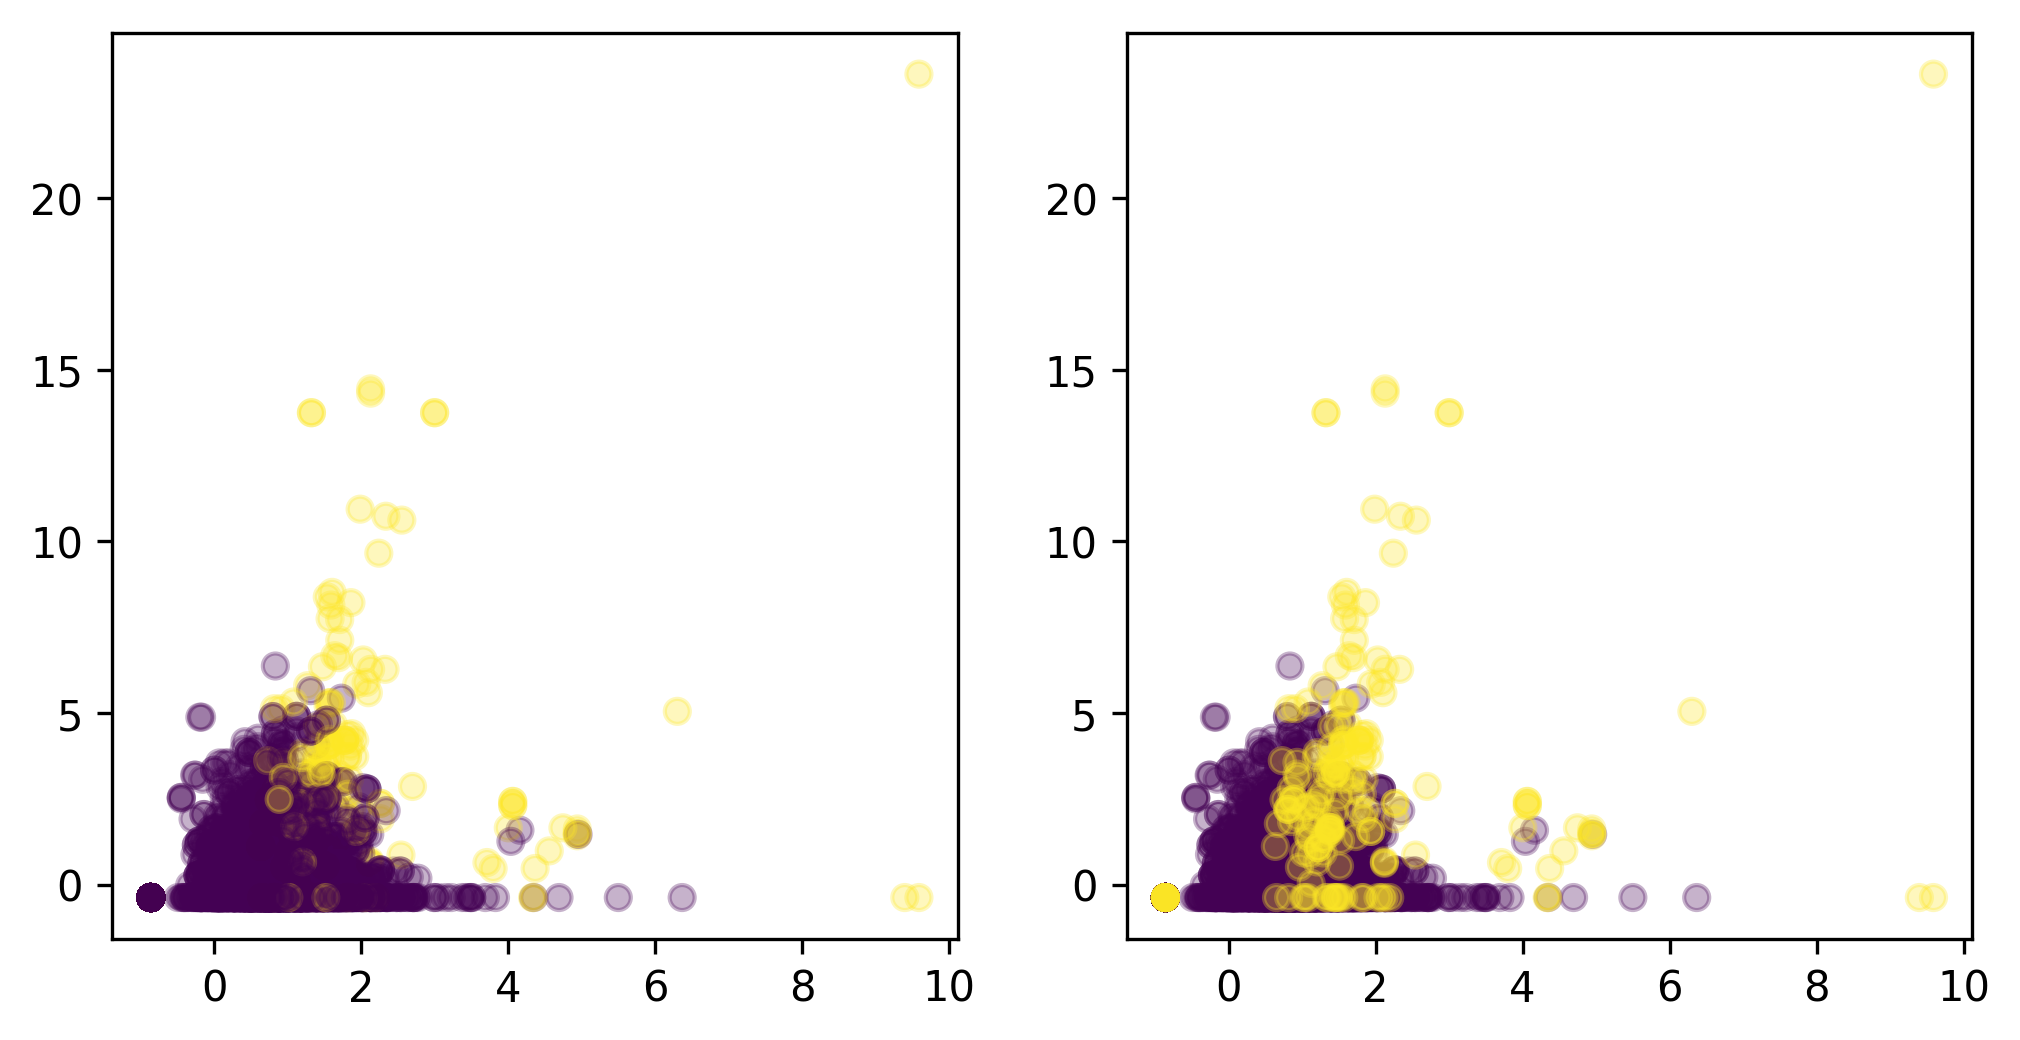

In [127]:
sorting = np.argsort(y_train)
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
axes[0].scatter(X_train[:, 3], X_train[:, 4], c=y_train[:], alpha=.3)
axes[1].scatter(X_train[sorting, 3], X_train[sorting, 4], c=y_train[sorting], alpha=.3)

In [18]:
from sklearn.linear_model import LogisticRegression
scores = cross_val_score(LogisticRegression(), X_train, y_train, cv=10, scoring='roc_auc')
print(scores.mean())

0.919622716696


In [19]:
from sklearn.linear_model import LogisticRegressionCV
scores = cross_val_score(LogisticRegressionCV(scoring='roc_auc'), X_train, y_train, cv=10, scoring='roc_auc')
print(scores.mean())

0.918680168801


In [28]:
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from imblearn.under_sampling import RandomUnderSampler

In [38]:
rus = RandomUnderSampler(replacement=False)
X_train_subsample, y_train_subsample = rus.fit_sample(X_train, y_train)
print(X_train.shape)
print(X_train_subsample.shape)
print(np.bincount(y_train_subsample))

(8387, 6)
(390, 6)
[195 195]


In [47]:
undersample_pipe = make_imb_pipeline(RandomUnderSampler(), LogisticRegressionCV())
scores = cross_val_score(undersample_pipe, X_train, y_train, cv=10, scoring='roc_auc')
print(np.mean(scores))

0.916512922589


In [41]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
X_train_oversample, y_train_oversample = ros.fit_sample(X_train, y_train)
print(X_train.shape)
print(X_train_oversample.shape)
print(np.bincount(y_train_oversample))

(8387, 6)
(16384, 6)
[8192 8192]


In [67]:
oversample_pipe = make_imb_pipeline(RandomOverSampler(), LogisticRegression())
scores = cross_val_score(oversample_pipe, X_train, y_train, cv=10, scoring='roc_auc')
print(np.mean(scores))

0.917755942193


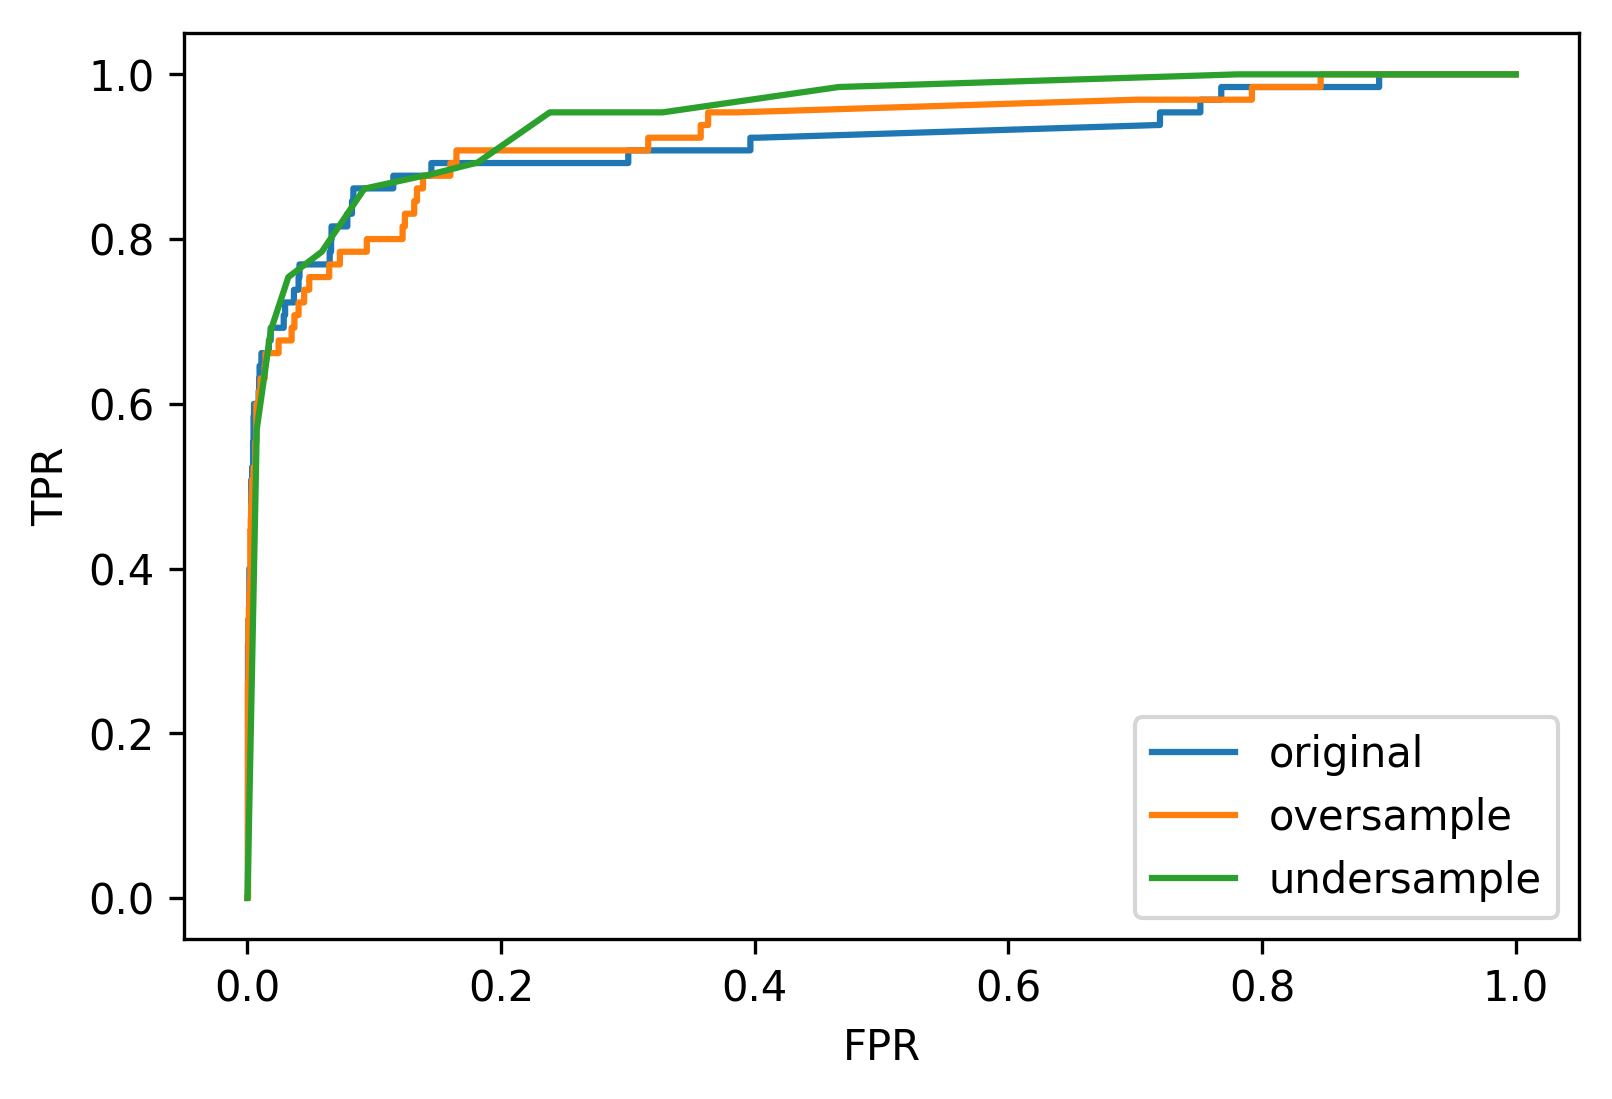

In [68]:
from sklearn.metrics import roc_curve
oversample_pipe.fit(X_train, y_train)
props_oversample = oversample_pipe.predict_proba(X_test)[:, 1]
fpr_over, tpr_over, _ = roc_curve(y_test, props_oversample)

undersample_pipe.fit(X_train, y_train)
props_undersample = undersample_pipe.predict_proba(X_test)[:, 1]
fpr_under, tpr_under, _ = roc_curve(y_test, props_undersample)

lr = LogisticRegression().fit(X_train, y_train)
props_original = lr.predict_proba(X_test)[:, 1]
fpr_org, tpr_org, _ = roc_curve(y_test, props_original)

plt.plot(fpr_org, tpr_org, label="original")
plt.plot(fpr_over, tpr_over, label="oversample")
plt.plot(fpr_under, tpr_under, label="undersample")
plt.legend()
plt.xlabel("FPR")
plt.ylabel("TPR")

In [64]:
from sklearn.ensemble import RandomForestClassifier
scores = cross_val_score(RandomForestClassifier(n_estimators=100), X_train, y_train, cv=10, scoring='roc_auc')
print(np.mean(scores))

0.94143939841


In [65]:
undersample_pipe = make_imb_pipeline(RandomUnderSampler(), RandomForestClassifier())
scores = cross_val_score(undersample_pipe, X_train, y_train, cv=10, scoring='roc_auc')
print(np.mean(scores))

0.944496565836


In [69]:
oversample_pipe = make_imb_pipeline(RandomOverSampler(), RandomForestClassifier())
scores = cross_val_score(oversample_pipe, X_train, y_train, cv=10, scoring='roc_auc')
print(np.mean(scores))

0.891189066122


# Class Weights

In [71]:
from sklearn.linear_model import LogisticRegression
scores = cross_val_score(LogisticRegression(class_weight='balanced'), X_train, y_train, cv=10, scoring='roc_auc')
print(scores.mean())

0.917567920152


In [75]:
from sklearn.ensemble import RandomForestClassifier
scores = cross_val_score(RandomForestClassifier(n_estimators=100, class_weight='balanced'),
                         X_train, y_train, cv=10, scoring='roc_auc')
print(np.mean(scores))

0.91679851501


# Resampled Ensembles

In [81]:
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
def make_resample_tree(random_state=0):
    tree = make_imb_pipeline(RandomUnderSampler(random_state=random_state, replacement=True),
                             DecisionTreeClassifier(max_features='auto', random_state=random_state))
    return "tree_i".format(random_state), tree
classifiers = [make_resample_tree(i) for i in range(100)]
resampled_rf = VotingClassifier(classifiers, voting='soft')

In [83]:
scores = cross_val_score(resampled_rf, X_train, y_train, cv=10, scoring='roc_auc')
print(np.mean(scores))

0.960342658946


In [91]:
from sklearn.base import clone

def make_resampled_ensemble(estimator, n_estimators=100):
    estimators = []
    for i in range(n_estimators):
        est = clone(estimator)
        if hasattr(est, "random_state"):
            est.random_state = i
        pipe = make_imb_pipeline(RandomUnderSampler(random_state=i, replacement=True),
                                 est)
        estimators.append(("est_i".format(i), pipe))
    return VotingClassifier(estimators, voting="soft")

In [93]:
resampled_tree_test = make_resampled_ensemble(DecisionTreeClassifier(max_features='auto'))

scores = cross_val_score(resampled_tree_test, X_train, y_train, cv=10, scoring='roc_auc')
print(np.mean(scores))

0.960342658946


In [96]:
resampled_lr = make_resampled_ensemble(LogisticRegression())

scores = cross_val_score(resampled_lr, X_train, y_train, cv=10, scoring='roc_auc')
print(np.mean(scores))

0.91984996634


# Edited Nearest Neighbors

In [130]:
from imblearn.under_sampling import EditedNearestNeighbours
enn = EditedNearestNeighbours(n_neighbors=5)
X_train_enn, y_train_enn = enn.fit_sample(X_train, y_train)

enn_mode = EditedNearestNeighbours(kind_sel="mode", n_neighbors=5)
X_train_enn_mode, y_train_enn_mode = enn_mode.fit_sample(X_train, y_train)

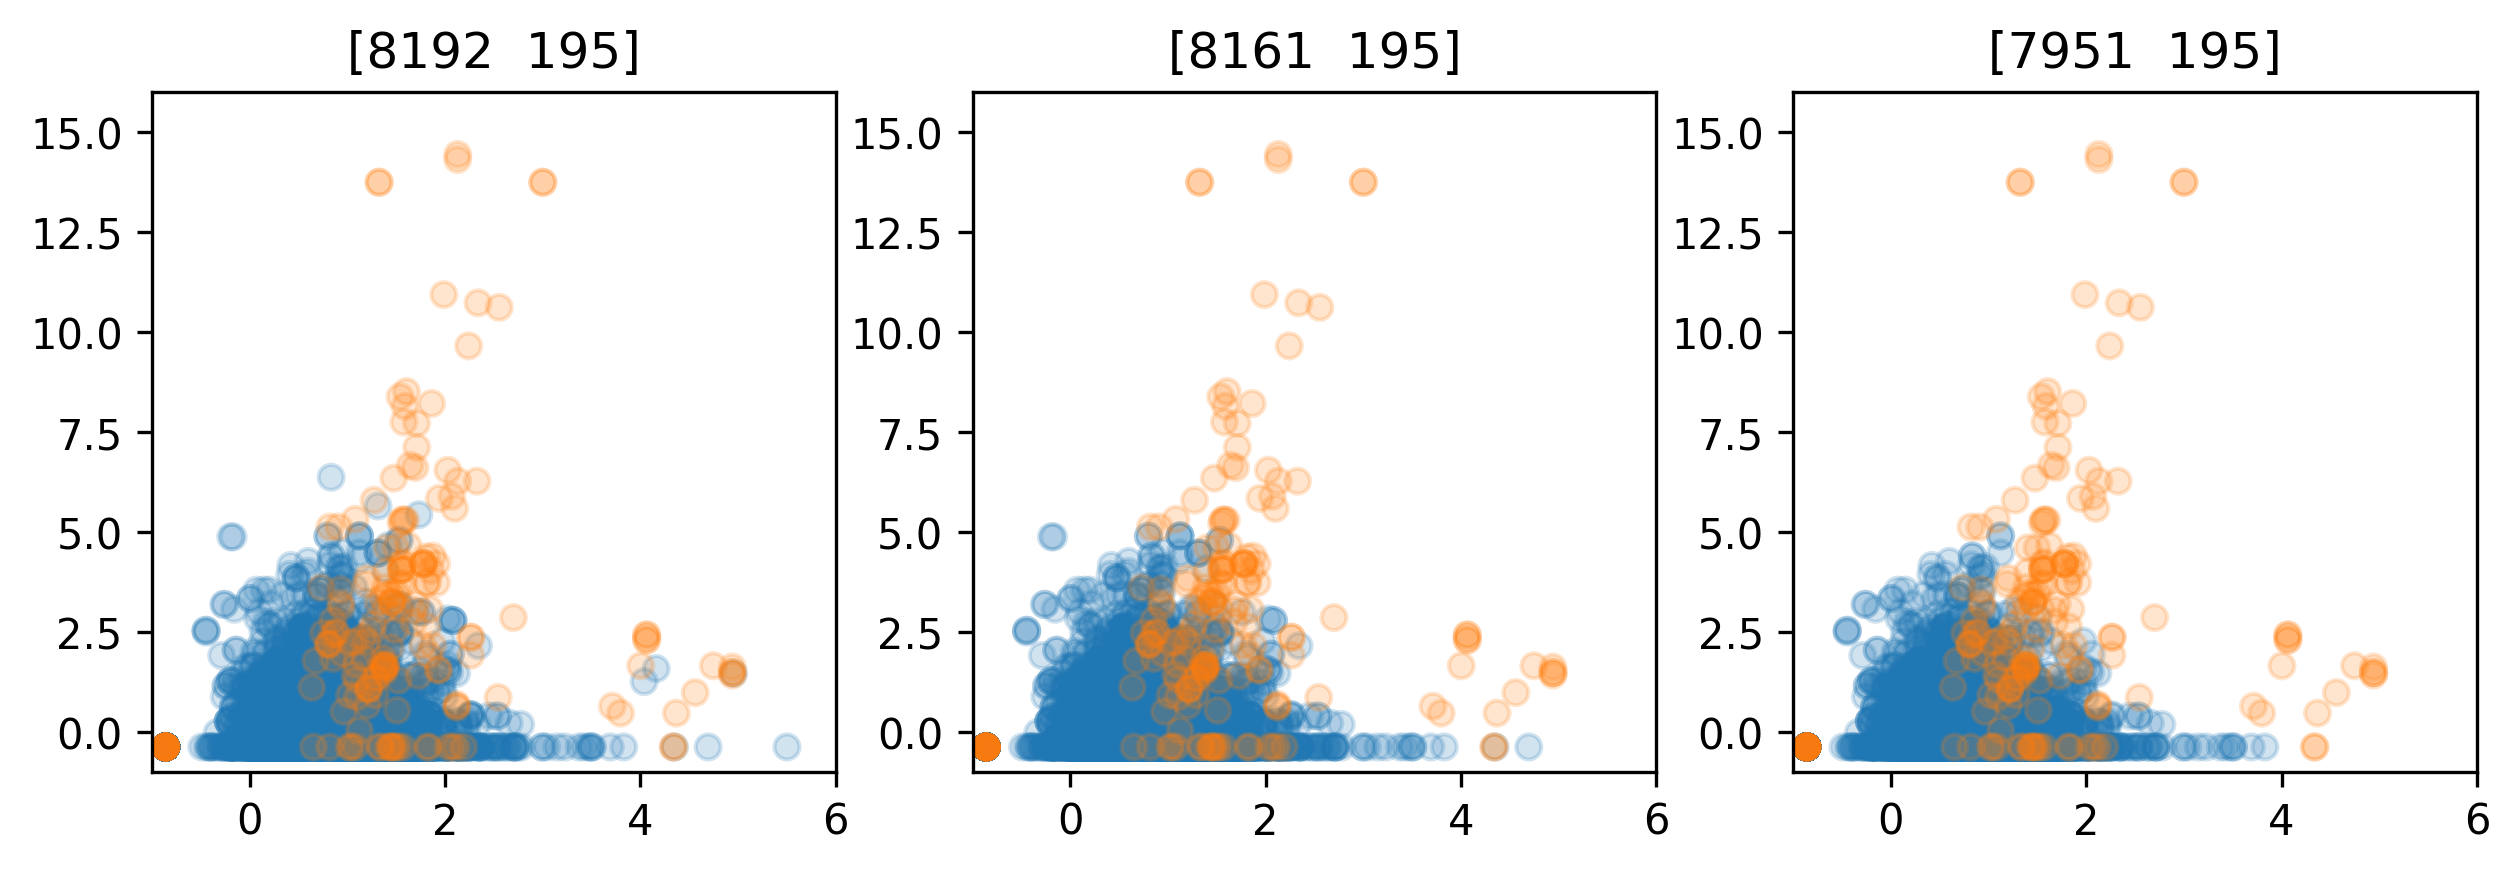

In [131]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))
datasets = [(X_train, y_train), (X_train_enn_mode, y_train_enn_mode), (X_train_enn, y_train_enn)]
for ax, (X_, y_) in zip(axes, datasets):
    # make sure we plot the orange over the blue
    sorting = np.argsort(y_)
    ax.scatter(X_[sorting, 3], X_[sorting, 4], c=plt.cm.Vega10(y_[sorting]), alpha=.2)
    ax.set_xlim(-1, 6)
    ax.set_ylim(-1, 16)
    ax.set_title(np.bincount(y_))

In [132]:
enn_pipe = make_imb_pipeline(EditedNearestNeighbours(n_neighbors=5), LogisticRegression())
scores = cross_val_score(enn_pipe, X_train, y_train, cv=10, scoring='roc_auc')
print(np.mean(scores))

0.920155354576


In [133]:
from sklearn.model_selection import GridSearchCV
param_grid = {'editednearestneighbours__n_neighbors': [3, 5, 9, 15]}
search = GridSearchCV(enn_pipe, param_grid, cv=10)
search.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=Pipeline(steps=[('editednearestneighbours', EditedNearestNeighbours(kind_sel='all', n_jobs=1, n_neighbors=5,
            random_state=None, return_indices=False, size_ngh=None)), ('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'editednearestneighbours__n_neighbors': [3, 5, 9, 15]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

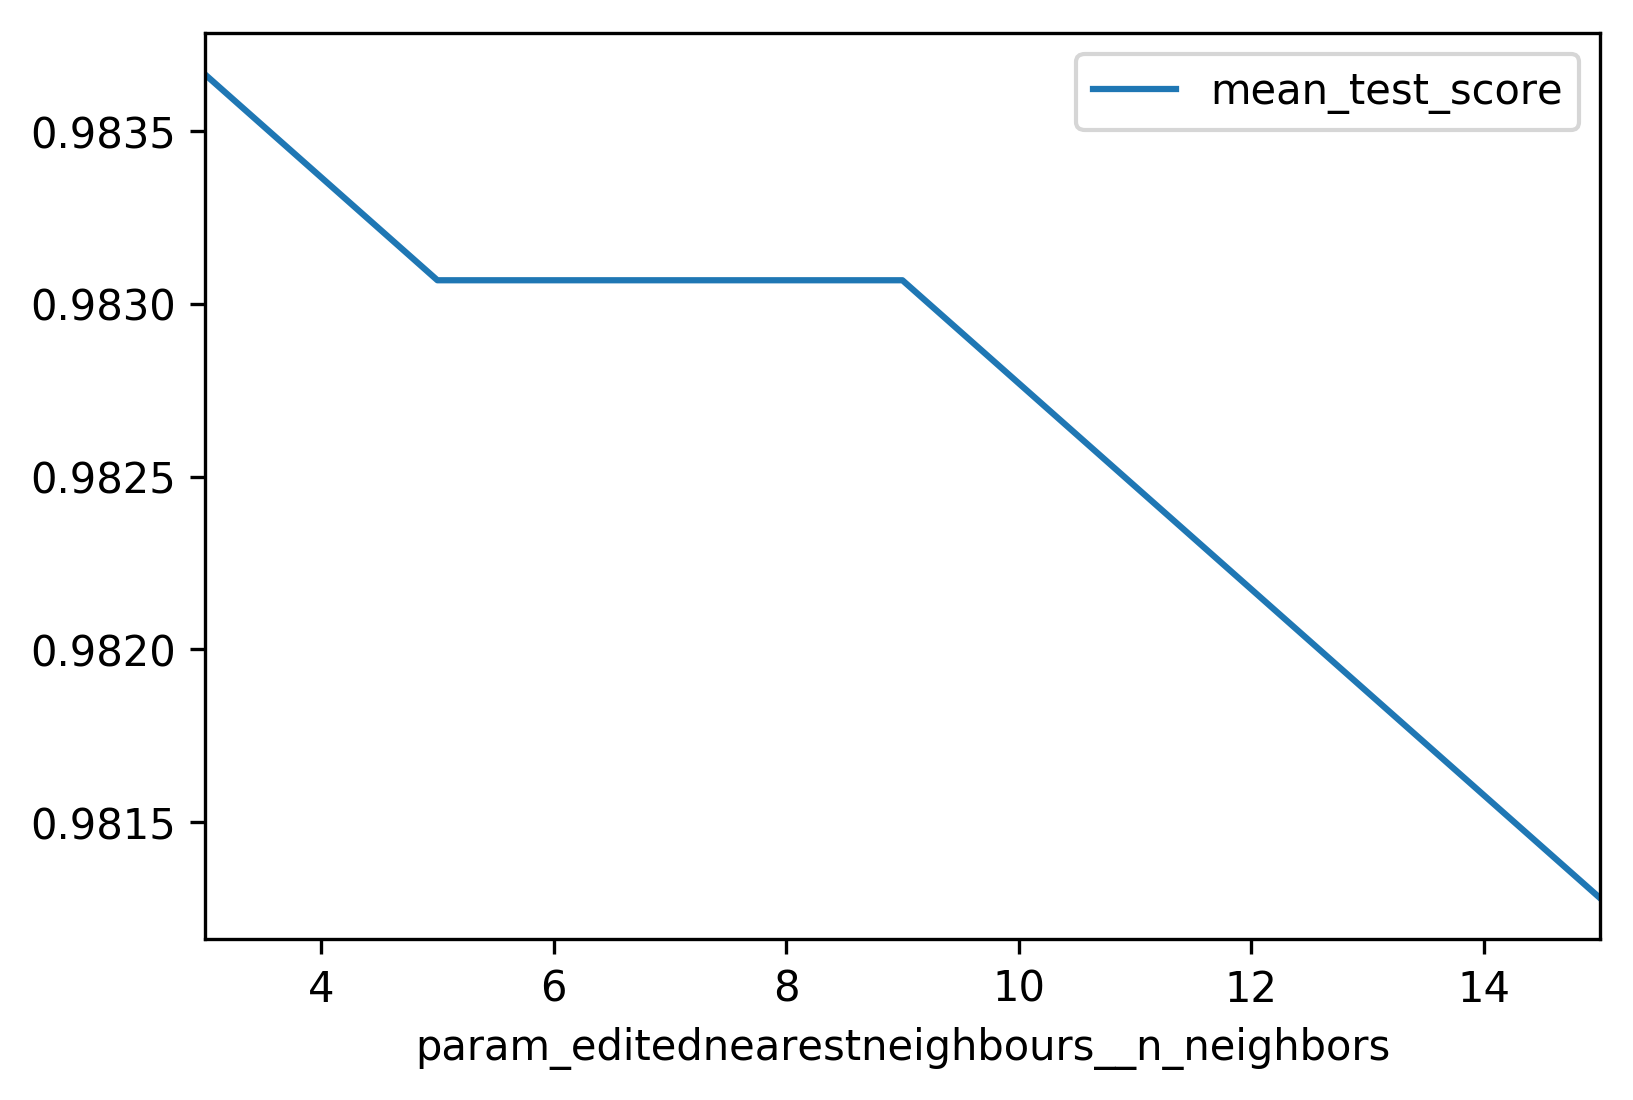

In [139]:
results = pd.DataFrame(search.cv_results_)
results.plot("param_editednearestneighbours__n_neighbors", "mean_test_score")

# SMOTE